In [2]:
import string
import utils
import random
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pickle

from scipy import optimize
from utils import random_idx
from utils import utils
from utils import lang_vectors_utils as lvu
from utils import verb_mappings as vm
%matplotlib inline

k = 500
N = 10000
NUM_CLASSES = 2
cluster_size = 3
ordered = 1
alphabet = string.lowercase + ' '
RI_letters = random_idx.generate_letter_id_vectors(N, k, alphabet)

def read_examples(filepath):
    examples = []
    with open(filepath, "r") as f:
        for line in f:
            for word in line.split():
                examples.append(word)
    return examples

edsets = ["ed.txt", "ed10000.txt", "ed5000.txt", "ed3000.txt", "ed1000.txt"]
edlabels = ["ed.txt", "ed10000.txt", "ed5000.txt", "ed3000.txt", "ed1000.txt"]
# oh shit -ed verbs are actually -d and -ed verbs in the same bag of words. i'm keeping them as the same class

height has been deprecated.

2016-11-02 15:58


In [3]:
print RI_letters

[[ 0.  0.  0. ...,  1.  0. -1.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]


In [4]:
RI_letters = np.random.rand(27, N)
RI_letters[RI_letters<.5] = -1
RI_letters[RI_letters>.5] = 1

RI_letters
print RI_letters

[[ 1. -1.  1. ..., -1.  1.  1.]
 [ 1. -1.  1. ...,  1.  1. -1.]
 [-1.  1.  1. ..., -1.  1.  1.]
 ..., 
 [ 1.  1.  1. ..., -1. -1.  1.]
 [-1.  1.  1. ...,  1.  1. -1.]
 [ 1.  1.  1. ...,  1.  1. -1.]]


In [5]:
# only working with -ed verbs for now
past = read_examples("wickle_train/edsets/ed1000.txt")
present = read_examples("wickle_train/edlabels/ed1000.txt")

In [56]:
def wv(word, alphabet, RI_letters, cluster_size=3, N=1000, ordered=1):
    """
    word vectors encoded as a sum of their trigrams. Thus a word vector is just like a language
    vector of yore, with a word of L letters + two spaces yielding L trigrams.
    
      j u
    j u m
    u m p
    m p 

    """
    word = " " + word + " "
    wordv = np.zeros((1,N))
    for i in range(len(word)-cluster_size):
        ngram = word[i:i+cluster_size]
        z = np.ones(N)
        for j in ngram:
            z = np.multiply(z, RI_letters[alphabet.index(j)])
            z = np.roll(z, 1)
        wordv += np.array([z])
    return wordv

"""
Mapping the present-tense verbs to past tense using
high-D vector arithmetic/algebra (rather than a neural
net) will take some experimenting because the simplest
idea is sure to fail.  First we make a Word Vector for
each basic verb and each past verb.  Word vectors are
hypervectors, and they are encoded as a sum of their
trigrams.  Thus a word vector is just like a language
vector of yore, with a word of L letters + two spaces
yielding L trigrams.

Now here is the simple idea (the one that will fail in
the end): form a mapping vector from a present-tense
verb to a past-tense verb by multiplying the two word
vectors.  This same mapping vector will turn the
past-tense verb to the present-tense verb.  These
mappings are not exact because the word vectors are
not binary +1s and -1s.

The next step is to add all the present-tense word
vectors into a single vector, call it the Present
Vector, and all the past-tense word vectors into a
single Past Vector, and then multiply the two.  That
will be the master mapping vector with which to start
experimenting (and it is the one that will have
problems).
"""
pasts = np.zeros((len(past), N))
presents = np.zeros((len(past), N))
mapping_vecs = np.zeros((len(past), N))

RI2 = 2 * ( np.random.randn(len(alphabet),N) < 0) - 1

for i in range(len(past)):
    pasts[i] = wv(past[i], alphabet, RI_letters, cluster_size, N, ordered) 
    presents[i] = wv(present[i], alphabet, RI2, cluster_size, N, ordered)
    pasts[i] = pasts[i] / (len(past[i]))
    presents[i] = presents[i] / (len(present[i]))
    
    mapping_vecs[i] = vm.mapping_vec(presents[i], pasts[i])

bindings = pasts*presents 

M = 100
master = np.sum(bindings[:M,:],axis=0)

In [57]:
# plt.plot(past_vec.T)
pasts.shape

(1000, 10000)

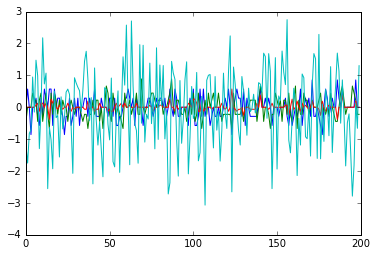

In [58]:
plt.plot(presents[i][:200])
plt.plot(pasts[i][:200])
plt.plot(pasts[i][:200]*presents[i][:200])
plt.plot(master[:200])

In [59]:
"""
Test number 1: see if the word vector for a
present-tense verb, when multiplied by the master
mapping vector, produces anything like the word vector
for the same word in the past tense.  Sometimes it
works and sometimes it fails.  We can then start
looking at when and how it fails, and try to fix the
problem.  There are lots of tricks in our bag to fix
it with!
"""
# need to normalize the dot products
dot_prods = np.zeros(len(past))
for i in range(M):
    pastHat = presents[i]*master
    dot_prods[i] = pasts[i].dot(pastHat)
dot_prods = dot_prods
similarities = np.where(dot_prods>0, 1, 0)
similarity = np.sum(similarities)/float(len(past))
print ("similarity", similarity)
print "present, past, pastHat, similarity"
for i in range(M):
    print (present[i], past[i], dot_prods[i])

('similarity', 0.10000000000000001)
present, past, pastHat, similarity
('wist', 'wisted', 273.83014727987154)
('soberiz', 'soberized', 164.2084715963567)
('revegetat', 'revegetated', 111.18960384040597)
('finess', 'finessed', 187.26334759501123)
('impersonaliz', 'impersonalized', 57.33657293725571)
('cuss', 'cussed', 250.83079291691431)
('overag', 'overaged', 196.09212744975611)
('retailor', 'retailored', 113.55191164227926)
('barrag', 'barraged', 162.21292225442045)
('clott', 'clotted', 178.15055799475965)
('nonlead', 'nonleaded', 141.45672814580377)
('disclaim', 'disclaimed', 117.53965709637586)
('knarr', 'knarred', 211.24762407993501)
('sparkplugg', 'sparkplugged', 72.543189764347844)
('demount', 'demounted', 211.64472527161601)
('croon', 'crooned', 185.34238389994692)
('mutini', 'mutinied', 170.77509157679197)
('pigg', 'pigged', 250.85366191542661)
('attract', 'attracted', 111.66169560028104)
('flench', 'flenched', 139.11514351321335)
('institutionalis', 'institutionalised', 31.871